In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from functions.model2 import GAN
import datetime
import json
from functions.data_preperation import process_model_data
from functions.q_generator import four_qubit_circuit_tickers

2.16.2
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def shuffle_data(feature_data, real_data):
    # feature_data: numpy array
    # real_data: tf.Tensor

    # Make sure we have the same number of samples
    assert feature_data.shape[0] == real_data.shape[0], "Mismatched number of samples"

    # Generate shuffled indices
    indices = np.arange(feature_data.shape[0])
    np.random.shuffle(indices)

    # Apply to both
    feature_shuffled = feature_data[indices]
    real_shuffled = tf.gather(real_data, indices)

    return feature_shuffled, real_shuffled

In [3]:
DISCRIMINATOR_STEPS = 5
DISCRIMINATOR_LAYER_MULTIPLIER =2
GP_WEIGHT = 10
LEARNING_RATE = 1e-5
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
BATCH_SIZE = 32
EPOCHS = 100
D_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)
#G_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2)

2025-10-03 10:27:56.212862: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-03 10:27:56.212881: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-03 10:27:56.212886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-03 10:27:56.212903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-03 10:27:56.212914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load data

In [4]:
targets = ["OC_next", "CO_next","High","Low"]
features = [
    "Close", "High", "Low", "Open", 
    "Volume", "MACD", "Signal_Line", "EMA_20",
    "EMA_50", "SMA_30", "RSI_14", "ATR_14",
    "prev_High", "prev_Low", "prev_Close", "prev_Open"
]
tickers = ['GOOG','AAPL']

In [5]:
train_data = process_model_data_four(targets, features, tickers)  # feature_data, target_data

y = train_data[1]

plt.scatter(y[:, 0], y[:, 4], alpha=0.7)
plt.xlabel('GOOG OC_next')
plt.ylabel('AAPL OC_next')
plt.title('AAPL vs GOOG')
plt.grid(True)
plt.show()

NameError: name 'process_model_data_four' is not defined

## Load generator from Qiskit

80


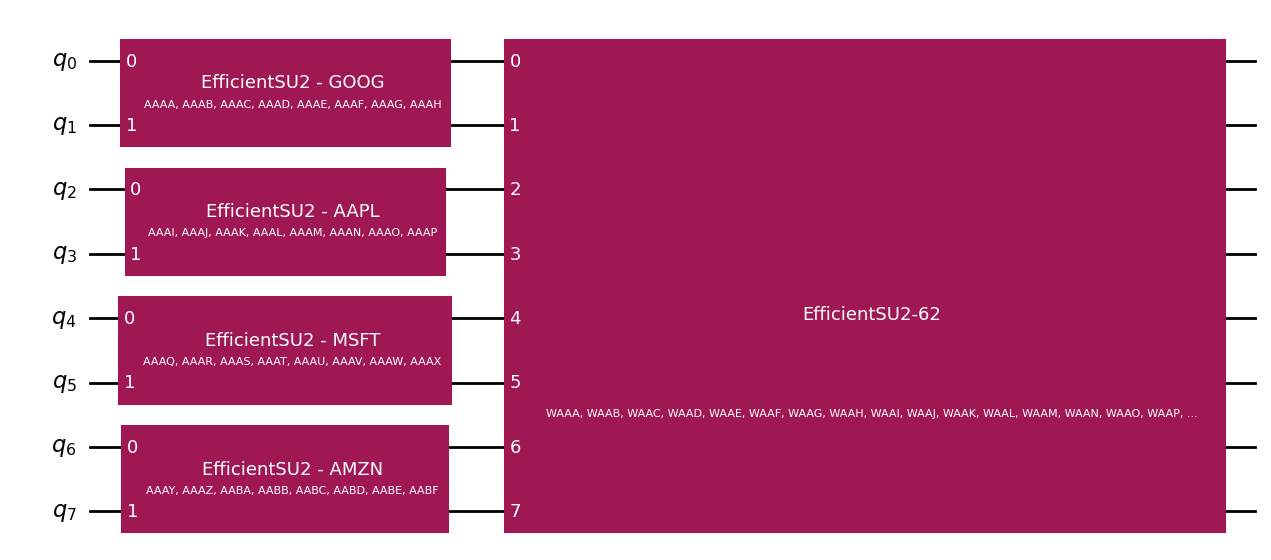

In [ ]:
qc= four_qubit_circuit_tickers(tickers)
print(len(list(qc.parameters)))
qc.draw('mpl')

In [ ]:
qgan = GAN(
    discriminator_steps= DISCRIMINATOR_STEPS,
    gp_weight= GP_WEIGHT,
    n_tickers= len(tickers),
    n_features= len(features),
    n_outputs= len(targets),
    generator_qiskit=qc,
    discriminator_layer_multiplier=DISCRIMINATOR_LAYER_MULTIPLIER,
    on_hardware= False,
    batch_size= BATCH_SIZE,
)

qgan.compile(
    d_optimizer = D_OPTIMIZER,
    
)

Trial 2Q Depth: 10


/Users/a01milner/Documents/Schro-horse/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
#os.mkdir("models/")
time = datetime.datetime.now().strftime("%d%m.%H%M")
model_path = f"models/models_{time}"
os.mkdir(model_path)

In [ ]:
import os
import numpy as np
import json
from tensorflow.keras.callbacks import Callback

class SaveWeightsAndMetrics(Callback):
    def __init__(self, qgan, save_dir="checkpoints", save_weights=True, save_metrics=True):
        super().__init__()
        self.qgan = qgan   # <-- store GAN object here
        self.save_dir = save_dir
        self.save_weights = save_weights
        self.save_metrics = save_metrics
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save generator weights
        if self.save_weights:
            weights_path = os.path.join(self.save_dir, f"generator_weights_epoch{epoch+1}.npy")
            weights_list = [w.numpy() for w in self.qgan.generator_weights]
            np.save(weights_path, weights_list)
            print(f"✅ Saved generator weights to {weights_path}")

        # Save metrics
        if self.save_metrics:
            metrics_path = os.path.join(self.save_dir, f"metrics_epoch{epoch+1}.json")
            with open(metrics_path, "w") as f:
                json.dump({k: float(v) for k, v in logs.items()}, f, indent=2)
            print(f"📊 Saved metrics to {metrics_path}")


In [ ]:
callbacks = [
    SaveWeightsAndMetrics(qgan=qgan, save_dir=f"{model_path}/logs")
]

In [ ]:
feature_data, real_data = train_data
feature_data, real_data = shuffle_data(feature_data,real_data)

In [ ]:
qgan.fit(
    feature_data=feature_data.astype(np.float32),
    real_data=real_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100 - {'d_loss': 5.743552550673485, 'g_loss': -0.2029675142839551, 'd_gp': 0.5650811456143856, 'd_wass_loss': 0.09274128498509526, 'real_score': 0.11022622394375503, 'gen_score': 0.2029675142839551}
✅ Saved generator weights to models/models_0310.0941/logs/generator_weights_epoch1.npy
📊 Saved metrics to models/models_0310.0941/logs/metrics_epoch1.json
Epoch 2/100 - {'d_loss': 5.792652487754822, 'g_loss': -0.3301944984123111, 'd_gp': 0.5579756945371628, 'd_wass_loss': 0.21289577661082149, 'real_score': 0.11729869083501399, 'gen_score': 0.3301944984123111}
✅ Saved generator weights to models/models_0310.0941/logs/generator_weights_epoch2.npy
📊 Saved metrics to models/models_0310.0941/logs/metrics_epoch2.json
Epoch 3/100 - {'d_loss': 5.594379156827927, 'g_loss': -0.3914517229422927, 'd_gp': 0.5326123423874378, 'd_wass_loss': 0.26825621630996466, 'real_score': 0.12319554481655359, 'gen_score': 0.3914517229422927}
✅ Saved generator weights to models/models_0310.0941/logs/generator_w

In [ ]:
qgan.generator_save(f"{model_path}/generator.npy") 
qgan.discriminator.save(f"{model_path}/discriminator.keras")

Generator weights saved to models/models_0310.0109/generator.npy
